In [86]:
import pandas as pd
import datetime as dt
import json

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
%matplotlib inline
plt.style.use('fivethirtyeight')

In [87]:
import statsmodels.api as sm

ModuleNotFoundError: No module named 'statsmodels'

## Monthly tonnage

In [7]:
df = pd.read_csv('monthly_tonnage.csv', na_values='NaN')

## make datetime, separate the year
df.MONTH = pd.to_datetime(df.MONTH)
df['year'] = df.MONTH.astype(str).str.extract(r'^(.*)-.*-.*').astype(int)
df.BOROUGH_ID = df.BOROUGH_ID.astype(str)

df = df[df.year > 2008] ## just for the past 10 years

## some math to get the percents and totals
df['total_recycled'] = df.PAPERTONSCOLLECTED + df.MGPTONSCOLLECTED
df['percent_recycled'] = df['total_recycled'] / df.REFUSETONSCOLLECTED

# give the borough code
def get_boro_code(x):
    return x.BOROUGH_ID + "{:02d}".format(x.COMMUNITYDISTRICT)
df['borough_code'] = df.apply(get_boro_code, axis=1)

In [8]:
df.head(3)

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID,year,total_recycled,percent_recycled,borough_code
3,2012-03-01,Manhattan,1,1194.4,341.6,210.8,NaN,NaN,NaN,NaN,1,2012,552.4,0.462492,101
9,2012-01-01,Brooklyn,7,3156.7,436.6,343.4,NaN,NaN,NaN,20.1,3,2012,780.0,0.247093,307
13,2016-11-01,Brooklyn,7,3356.9,424.4,380.3,120.1,NaN,2.5,NaN,3,2016,804.7,0.239715,307


In [9]:
recycled_2019_df = df[df.year == 2019].groupby('borough_code').percent_recycled.mean().reset_index()

recycled_2019_df.to_csv('percent_recycled_2019.csv', index=False)

In [10]:
# open the file
with open('community-districts.json') as f:
    data = json.load(f)

In [11]:
recycled_2019_df.head()

,borough_code,percent_recycled
0,101,0.473798
1,102,0.416603
2,103,0.220166
3,104,0.387499
4,105,0.352951


In [14]:
for district in data['objects']['community-districts']['geometries']:
    print(district['properties']['boro_cd'])

311
313
312
304
206
208
212
226
317
309
306
404
316
412
405
205
482
315
207
105
305
204
308
355
410
483
314
302
303
101
307
413
228
310
403
110
407
411
111
501
201
112
202
203
164
103
102
104
107
109
108
408
481
484
406
409
503
414
209
210
480
318
356
106
301
211
227
401
402
502
595


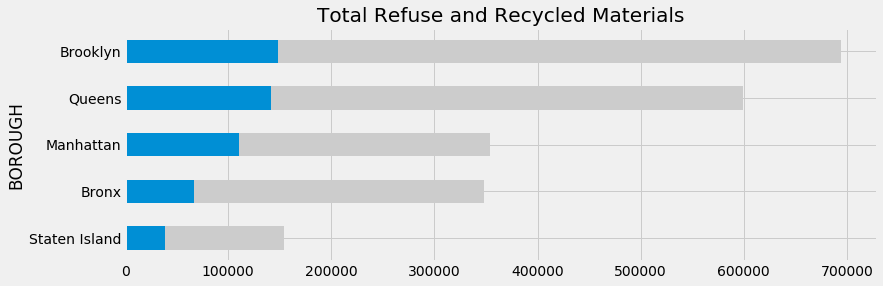

In [15]:
ax = df[df.year == 2019].groupby('BOROUGH').REFUSETONSCOLLECTED.sum().sort_values().plot(kind='barh', title='Total Recycled Materials', figsize=(12,4), color='#cccccc')
df[df.year == 2019].groupby('BOROUGH').total_recycled.sum().sort_values().plot(kind='barh', title='Total Refuse and Recycled Materials', figsize=(12,4), ax=ax)

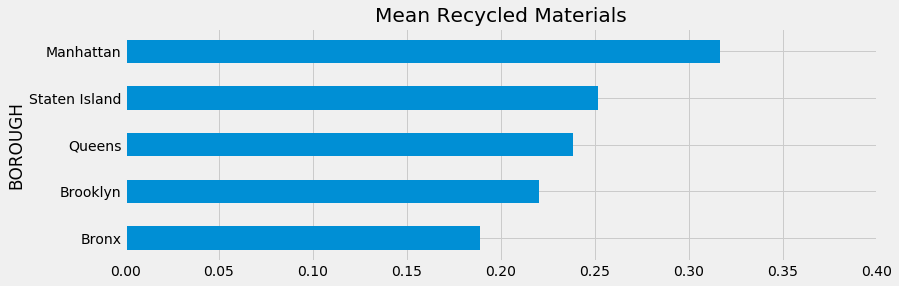

In [16]:
df[df.year == 2019].groupby('BOROUGH').percent_recycled.mean().sort_values().plot(kind='barh', title='Mean Recycled Materials', figsize=(12,4), xlim=(0,.4))

## Greatest shifts by district over time

In [19]:
bydist_2018 = df[df['year']==2018].groupby('borough_code').percent_recycled.mean().reset_index()
bydist_2009 = df[df['year']==2009].groupby('borough_code').percent_recycled.mean().reset_index()

bydist = pd.merge(bydist_2018,bydist_2009['percent_recycled'],left_index=True,right_index=True)
bydist.columns = ['borough_code','pct_recyc_2018','pct_recyc_2009']
bydist['pct_change'] = bydist['pct_recyc_2018'] / bydist['pct_recyc_2009'] - 1
bydist.to_csv('10-year-change.csv', index=False)
bydist.head()

,borough_code,pct_recyc_2018,pct_recyc_2009,pct_change
0,101,0.457068,0.525482,-0.130192
1,102,0.405030,0.357676,0.132396
2,103,0.220118,0.209310,0.051639
3,104,0.372049,0.376665,-0.012255
4,105,0.346514,0.334442,0.036097


In [20]:
print('The community districts that has the highest mean percent recycled')
print(df.groupby(['BOROUGH', 'COMMUNITYDISTRICT']).percent_recycled.mean().reset_index().sort_values('percent_recycled', ascending=False).head())
print('\n')
print('The community districts that has the lowest mean percent recycled')
print(df.groupby(['BOROUGH', 'COMMUNITYDISTRICT']).percent_recycled.mean().reset_index().sort_values('percent_recycled', ascending=True).head())

The community districts that has the highest mean percent recycled
      BOROUGH  COMMUNITYDISTRICT  percent_recycled
30  Manhattan                  1          0.456923
17   Brooklyn                  6          0.440357
31  Manhattan                  2          0.365111
33  Manhattan                  4          0.359387
36  Manhattan                  7          0.358198


The community districts that has the lowest mean percent recycled
     BOROUGH  COMMUNITYDISTRICT  percent_recycled
3      Bronx                  4          0.105543
0      Bronx                  1          0.105900
27  Brooklyn                 16          0.112781
8      Bronx                  9          0.116825
2      Bronx                  3          0.118954


## 311 data regarding missed recyling collections

Data is <code>311_Service_Requests_from_2010_to_Present.csv</code>

I grabbed and filtered the data on NYC Open Data and filtered it to only include DSNY complaints mentioning recycling

In [180]:
df_311 = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', usecols=['Unique Key', 'Created Date', 'Agency', 'Agency Name', 'Complaint Type', 'Descriptor','Location Type', 'Incident Zip', 'Incident Address', 'Street Name', 'City', 'Resolution Description', 'Community Board', 'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Latitude', 'Longitude', 'Borough'])
df_311['year'] = df_311['Created Date'].str.extract('\d+\/\d+\/(\d+)') ## this grabs the year

In [181]:
df_311.head(1)

,Unique Key,Created Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,City,Resolution Description,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Latitude,Longitude,year
0,44916024,11/13/2019 10:19:00 AM,DSNY,BCC - Queens West,Missed Collection (All Materials),1R Missed Recycling-All Materials,Sidewalk,11378.0,59-15 69 LANE,69 LANE,Maspeth,The Department of Sanitation is in the process...,05 QUEENS,QUEENS,1014336.0,203004.0,40.723825,-73.891457,2019


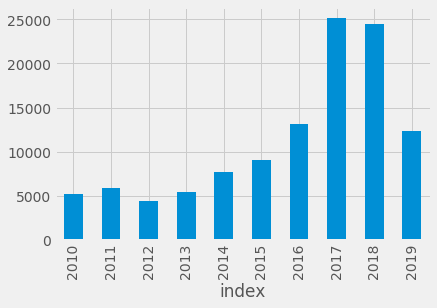

In [182]:
df_311.year.value_counts().reset_index().sort_values('index', ascending=True).plot(kind='bar', x='index', y='year', legend=False)

In [183]:
df_311['Community Board'].value_counts().head(10)

01 STATEN ISLAND    14443
03 STATEN ISLAND    13643
02 STATEN ISLAND     9859
01 BROOKLYN          5280
07 QUEENS            4791
12 BROOKLYN          3307
13 QUEENS            3241
03 BROOKLYN          2706
08 QUEENS            2661
12 QUEENS            2604
Name: Community Board, dtype: int64

In [186]:
df_311['Borough'].value_counts().head(6)

STATEN ISLAND    37952
BROOKLYN         32470
QUEENS           27294
MANHATTAN         8435
BRONX             6690
Unspecified          8
Name: Borough, dtype: int64

#Different Drop off locations

In [39]:
textile=pd.read_csv('Textile_Drop-Off_Locations_in_NYC.csv')
textile

,Address,BBL,BIN,BoroCD,Borough,CT2010,CouncilDistrict,Items_Accepted,Latitude,Longitude,...,Unit,Vendor_Name,Website,point,zipcode,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,606 E 89 St,3079930000,3224082,318,Brooklyn,964,46,"Clothing, Shoes, Accessories, Coats, Bedding A...",40.64240,-73.90993,...,NaN,Christian Church Of Canarsie,https://www1.nyc.gov/assets/donate/giveandfind...,POINT (-73.909932 40.642403),11236,13827,5.0,2.0,8.0,42.0
1,1133 Ogden Ave,2025260000,2088158,204,Bronx,199,16,"Clothing, Shoes",40.83659,-73.92780,...,NaN,Usagain LLC,http://www.usagain.com/,POINT (-73.927801 40.836595),10452,10930,50.0,5.0,42.0,27.0
2,10 Cebra Ave,5001150000,5002741,501,Staten Island,75,49,"Clothing, Shoes",40.63412,-74.08648,...,NaN,Planet Aid,http://www.planetaid.org/,POINT (-74.086477 40.63412199999999),10301,10369,4.0,1.0,13.0,74.0
3,1169 Bay St,5028290000,5107418,501,Staten Island,6,49,"Clothing, Shoes, Accessories",40.61481,-74.06644,...,NaN,Community Recycling LLC,https://www.communityrecycling.biz/,POINT (-74.066443 40.614809),10305,10692,4.0,1.0,13.0,74.0
4,137-42 Guy R Brewer Blvd,4123090000,4266757,412,Queens,294,28,"Clothing, Shoes, Accessories, Bedding and line...",40.67093,-73.77412,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.774124 40.670926),11434,24669,41.0,3.0,46.0,71.0
5,4844 Hylan Blvd,5063980000,5082010,503,Staten Island,176,51,"Clothing, Shoes, Coats, Accessories, Bedding, ...",40.52655,-74.16738,...,NaN,American Recycling Technologies Inc.,http://www.americanrecyclingtech.com/,POINT (-74.167381 40.526554),10312,10699,15.0,1.0,9.0,77.0
6,611 Grand Concourse,2023480000,2001076,204,Bronx,63,8,"Clothing, Shoes, Accessories, Bedding and line...",40.82045,-73.92674,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.926739 40.82045500000001),10451,10929,50.0,5.0,35.0,27.0
7,50-15 Roosevelt Ave,4013190000,4030851,402,Queens,25302,26,"Clothing, Shoes, Coats, Towels",40.74403,-73.91456,...,NaN,Carecycle Inc,carecyclecares.com/,POINT (-73.914562 40.74403),11377,14787,53.0,3.0,33.0,66.0
8,77-00 Queens Blvd,4024520000,4056456,404,Queens,479,25,"Clothing, Shoes, Accessories",40.73808,-73.88610,...,NaN,Community Recycling LLC,https://www.communityrecycling.biz/,POINT (-73.886102 40.738083),11373,14784,66.0,3.0,5.0,68.0
9,1809 Utica Ave,3077980000,3216426,318,Brooklyn,730,46,"Clothing, Shoes, Accessories, Bedding and line...",40.62799,-73.92747,...,NaN,Helpsy,https://www.helpsy.co/,POINT (-73.927472 40.62798999999998),11234,13825,5.0,2.0,8.0,38.0


In [65]:
bins=textile.BoroCD.value_counts().reset_index()
bins = bins.rename(columns={'index': 'BoroCD','BoroCD':'No.BoroCD'})
bins.head(3)

,BoroCD,No.BoroCD
0,501,59
1,412,57
2,318,43


In [91]:
borou=textile.Borough.value_counts().reset_index()
borou = borou.rename(columns={'index': 'Borough','Borough':'No_Borough'})
borou.head(5)

,Borough,No_Borough
0,Brooklyn,325
1,Queens,293
2,Manhattan,206
3,Bronx,205
4,Staten Island,112


In [72]:
prc=pd.read_csv('10-year-change.csv')
prc = prc.rename(columns={'borough_code': 'BoroCD'})
prc.head(5)

,BoroCD,pct_recyc_2018,pct_recyc_2009,pct_change
0,101,0.457068,0.525482,-0.130192
1,102,0.405030,0.357676,0.132396
2,103,0.220118,0.209310,0.051639
3,104,0.372049,0.376665,-0.012255
4,105,0.346514,0.334442,0.036097


In [75]:
join=bins.merge(prc, on='BoroCD')
join.head(5)

,BoroCD,No.BoroCD,pct_recyc_2018,pct_recyc_2009,pct_change
0,501,59,0.251563,0.235038,0.070306
1,412,57,0.193020,0.165567,0.165812
2,318,43,0.211713,0.218775,-0.032279
3,209,43,0.141494,0.102497,0.380468
4,305,41,0.141763,0.135917,0.043010


In [ ]:
secondjoin=join.merge(borou,on)

In [82]:
join.to_csv('bin-and-pct.csv')

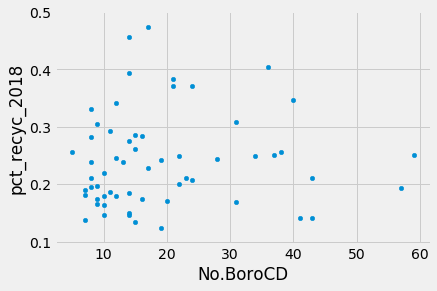

In [81]:
fig=join.plot(kind='scatter',x='No.BoroCD',y='pct_recyc_2018')